# 6.1.2 확률적 경사 하강법(SGD)
---

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[keys]

# 6.1.4 모멘텀
---

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

# 6.1.5 AdaGrad
---

In [3]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += gards[key] * gards[key]
            params[key] -= self.lr * grads[key]/(np.sqrt(self.h[key])+1e-7)

# 6.2 가중치의 초깃값
---

### 6.2.2 은닉층의 활성화값 분포
---

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

x = np.random.randn(1000,100) #1000개의 데이터
node_num = 100 #각 은닉층의 노드 수
hidden_layer_size = 5 #총 5개의 은닉층
activations = {} #활성화 결과(활성화 값)을 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    #표준편차가 1일때
    #w = np.random.randn(node_num, node_num) * 1
    #표준편차를 0.01 일때
    #w = np.random.randn(node_num, node_num) * 0.01
    #Xavier 초기값을 사용하였을 때
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x,w)
    z = sigmoid(a)
    activations[i] = z

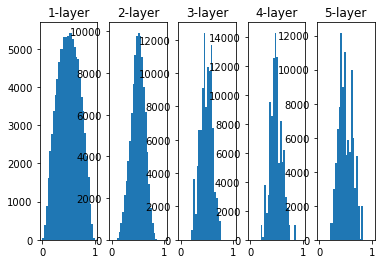

In [5]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1)+"-layer")
    plt.hist(a.flatten(), 30, range = (0, 1))
plt.show()

# 6.4 바른 학습을 위해
---

### 6.4.1 오버피팅
---

In [6]:
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True)
# 오버피팅 재현하기 위해서 학습 데이터 수를 줄인다
x_train = x_train[:300]
t_train = t_train[:300]

In [7]:
network = MultiLayerNet(input_size = 784, hidden_size_list = [100,100,100,100,100,100], output_size = 10)
optimizer = SGD(lr = 0.01)
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(10000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads =  network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0 :
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt+= 1
        if epoch_cnt >= max_epochs:
            break

### 6.4.3 드롭아웃
---

In [8]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape)>self.dropout_ration
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

# 6.5 적절한 하이퍼파라미터 값 찾기
---

### 6.5.1 검증 데이터
---


In [9]:
import sys, os
sys.path.append(os.pardir)
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

#훈련 데이터를 셔플
x_train, t_train = shuffle_dataset(x_train, t_train)

#20%를 검증 데이터로 분할
validation_rate = 0.2
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

- 훈련 데이터 : 매개변수 학습  

- 검증 데이터 : 하이퍼파라미터의 성능을 평가  

- 시험 데이터 : 신경망의 범용 성능을 평가  

### 6.5.3 하이퍼파라미터 최적화 구현하기

In [10]:
from common.trainer import Trainer

def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784,
                            hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd',
                      optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list

optimization_trial = 100
results_val = {}
results_train = {}

In [11]:
for _ in range(optimization_trial):
    weight_decay = 10 ** np.random.uniform(-8,-4)
    lr = 10 ** np.random.uniform(-6,-2)
    
    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

val acc:0.13691666666666666 | lr:3.106834808445675e-06, weight decay:1.2119464521723436e-06
val acc:0.098 | lr:1.0810943733907701e-06, weight decay:8.625194959670273e-05
val acc:0.89 | lr:0.0002163766488260702, weight decay:8.414930306868659e-05
val acc:0.1225 | lr:6.191158616278504e-06, weight decay:5.842770109385774e-06
val acc:0.87475 | lr:0.0001510304114285695, weight decay:1.5810438521414734e-07
val acc:0.9278333333333333 | lr:0.0005030925428954243, weight decay:3.120677406911768e-08
val acc:0.09216666666666666 | lr:1.4137855043169636e-06, weight decay:7.547630326579179e-05
val acc:0.968 | lr:0.005645893550979283, weight decay:4.187901269145063e-05
val acc:0.09925 | lr:1.709685495847927e-06, weight decay:1.1452000818655771e-07
val acc:0.96075 | lr:0.0027213190650062272, weight decay:3.776206334278005e-08
val acc:0.11641666666666667 | lr:1.0349429945210542e-06, weight decay:2.0402860412163462e-08
val acc:0.96175 | lr:0.0019354422304412651, weight decay:6.262348129159304e-06
val acc

val acc:0.12791666666666668 | lr:4.0072191349627195e-06, weight decay:1.4971649416654452e-08
val acc:0.16458333333333333 | lr:1.936001403408182e-06, weight decay:1.929286877860048e-06
val acc:0.76525 | lr:6.801663630197423e-05, weight decay:4.643199304904811e-07
val acc:0.16633333333333333 | lr:3.284569057385679e-06, weight decay:4.5277043223595524e-07


=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.96975) | lr:0.009670679277174084, weight decay:8.141969904396711e-05
Best-2(val acc:0.968) | lr:0.005645893550979283, weight decay:4.187901269145063e-05
Best-3(val acc:0.9670833333333333) | lr:0.008201293185096941, weight decay:5.310830620412764e-05
Best-4(val acc:0.9653333333333334) | lr:0.0059708428940421065, weight decay:4.1304948916864125e-07
Best-5(val acc:0.9645) | lr:0.003817887651834717, weight decay:1.597148973392731e-08
Best-6(val acc:0.9635) | lr:0.0033466570410879875, weight decay:4.538298081326221e-08
Best-7(val acc:0.96175) | lr:0.0019354422304412651, weight decay:6.262348129159304e-06
Best-8(val acc:0.96075) | lr:0.0027213190650062272, weight decay:3.776206334278005e-08
Best-9(val acc:0.9585833333333333) | lr:0.0017557676932367667, weight decay:3.591588279639057e-05
Best-10(val acc:0.9585) | lr:0.0018411932755400093, weight decay:4.994072781499758e-07
Best-11(val acc:0.9574166666666667) | lr:0.0

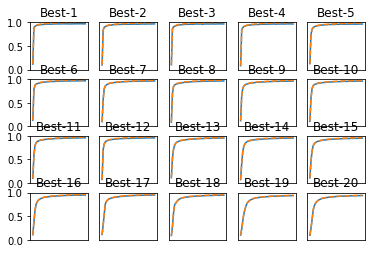

In [12]:
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x: x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5:
        plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()